# Computing nucleation rates with GASP

In [1]:
%matplotlib inline

In [2]:
import numpy as np  # Grids are stored as NumPy Arrays
import gasp         # GASP is what we're testing
import sys          # Needed to query size in bytes of data returned

Found 1 CUDA devices in this system
Device 0 : Quadro P2000
Number of SMs       : 8
Max SHMEM per block : 48 KB
Max Opt in shared   : 48 KB
Recommended ngrids  : 1024

Estimated largest L for shared memory code path : 109
(Assumes threadsPerBlock = 32)

Using CUDA device : 0


### Run a test nucleation swarm

In [3]:
%%time

L = 64
ngrids = 4*gasp.gpu_nsms*32
nsweeps = 50000
beta = 0.54
h = 0.07

grid_output_int = 100 # Should be a multiple of mag_output_int (not enforced?)
mag_output_int  = 100 # Note that the collective variable (be it magnetisation or cluster size) is computed only at this interval

frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, grid_output_int = grid_output_int, mag_output_int=mag_output_int);

 Sweep :      49300, Reached cv =   0.90 : 1024 , Unresolved :    0
CPU times: user 23.1 s, sys: 5.17 s, total: 28.3 s
Wall time: 1min 27s


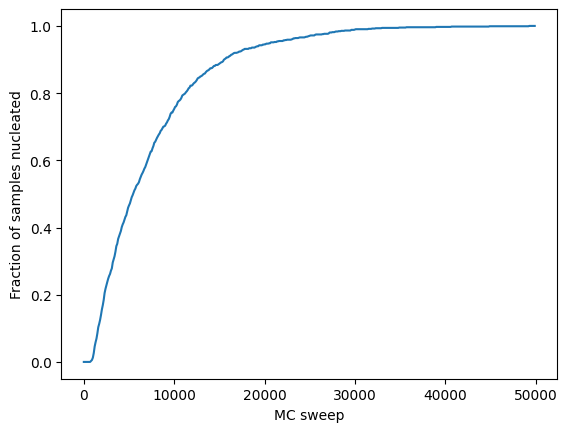

In [4]:
# Plot the fraction nucleated against MC sweep
import matplotlib.pyplot as plt

xdata = [ i * mag_output_int for i in range(nsweeps//mag_output_int)]
plt.ylabel("Fraction of samples nucleated")
plt.xlabel("MC sweep")
plt.plot(xdata, frac);

Now for some maths.

For an exponential distribution the probability that a nucleation event will occur after time $t$ is:
$$
P(t) = \exp{(-\lambda t)}.
$$
The cumulative probability that it will have occured at a time upto time $t$ is:
$$
C(t) = \int_0^t \exp{(-\lambda t')}\, dt' = 1 - \exp{(-\lambda t)}.
$$
So we want to fit this to our data and extract $\lambda$. If the fit is poor we know this isn't an exponential process, i.e. we're not in the regime where nucleation events are a random Poisson process.



In [5]:
# Define function to fit
import math as m
def fitfunc(t, rate, t_ind):
    return 1.0 - np.exp(-rate*(t-t_ind))    

# Test function
fitfunc(2000, 0.00008, 0)

0.14785621103378865

In [6]:
# Fit it
from scipy.optimize import curve_fit
# We should only fit from the last zero entry to account for induction time
arglist = np.argwhere(frac)
si = arglist[0][0] - 1

popt, pcov = curve_fit(fitfunc, xdata[si:], frac[si:], p0=[0.00008, 1000]) 
popt[0]

0.00015317589901484772

Nucleation rate at L=64 : 3.73965e-08 MCSS^-1


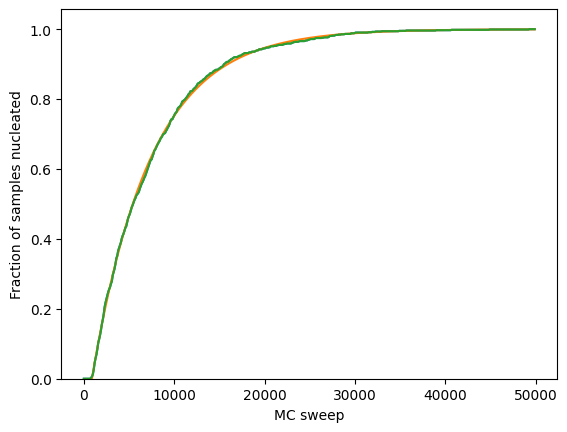

In [7]:
fitdata = [ fitfunc(t, *popt) for t in xdata]
plt.plot(xdata, frac)
plt.plot(xdata, fitdata)
plt.ylabel("Fraction of samples nucleated")
plt.xlabel("MC sweep")
plt.ylim(bottom=0.0)
plt.plot(xdata, frac);

krate = popt[0]/(L*L)
print(f"Nucleation rate at L={L} : {krate:.5e} MCSS^-1")

### Run with larger L and check for finite size effects
Creating a function for compute nucleation rate as we go

In [8]:
def compute_nucleation_rate(L, ngrids, nsweeps, beta, h):
    ''' Computes nucleation rate. '''
    
    frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, grid_output_int = grid_output_int, mag_output_int=mag_output_int);

    xdata = [ i * mag_output_int for i in range(nsweeps//mag_output_int)]
    arglist = np.argwhere(frac)
    si = arglist[0][0] - 1

    popt, pcov = curve_fit(fitfunc, xdata[si:], frac[si:], p0=[0.00008, 1000]) 
    krate = popt[0]/(L*L)
    return krate 

In [9]:
L=100
krate = compute_nucleation_rate(L, ngrids, nsweeps, beta, h)
print(f"Nucleation rate at L={L} : {krate:.5e} MCSS^-1")

 Sweep :      19400, Reached cv =   0.90 : 1024 , Unresolved :    0
Nucleation rate at L=100 : 3.35291e-08 MCSS^-1
